# LSTM Model for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: Standard Scaler

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
**Input** : the original data.   
ptbdb_normal.csv  
ptbdb_abnormal.csv  

Output: DNN model trained  
model_lstm_ptb.pkl  

In [7]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [8]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax


RawFiles = dict({
    'train': data_path + 'ptb_train_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_standard_oversamling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_lstm_ptb.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [9]:
X_train.shape

(16809, 187)

# LSTM with Standard Scaler and Oversampling

In [10]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape of the data
print("X_train shape:", X_train.shape)  # samples, timesteps, features
print("X_test shape:", X_test.shape)    # samples, timesteps, features


X_train shape: (16809, 187, 1)
X_test shape: (4203, 187, 1)


### Subsample

In [12]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Reshape the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the subsample fraction
sample_fraction = 0.2

# Create a random sample of indices
sample_indices = np.random.choice(len(X_train), size=int(len(X_train) * sample_fraction), replace=False)

# Use the subsample for training
X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]

# Define model
model = Sequential()  

# Input Layer
model.add(Input(shape=(X_train_sample.shape[1], X_train_sample.shape[2])))
model.add(LSTM(187, activation='relu', return_sequences=True))

# Hidden layers:
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.3))

# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid'))

# Choose an optimizer
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)

# Define lists for tracking metrics
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size and number of epochs
batch_size = 32
epochs = 50

# Training on the subsample
for epoch in range(epochs):
    history = model.fit(X_train_sample, y_train_sample, epochs=1, batch_size=batch_size, 
                        validation_data=(X_test, y_test), verbose=0, 
                        callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to the respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress at each 10th epoch for feedback
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 187, 187)       │       141,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,565 (662.36 KB)

 Trainable params: 169,565 (662.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 10/50 - Loss: nan, Val Loss: nan, Accuracy: 0.5144, Val Accuracy: 0.4966
Epoch 20/50 - Loss: nan, Val Loss: nan, Accuracy: 0.5144, Val Accuracy: 0.4966
Epoch 30/50 - Loss: nan, Val Loss: nan, Accuracy: 0.5144, Val Accuracy: 0.4966
Epoch 40/50 - Loss: nan, Val Loss: nan, Accuracy: 0.5144, Val Accuracy: 0.4966
Epoch 50/50 - Loss: nan, Val Loss: nan, Accuracy: 0.5144, Val Accuracy: 0.4966


### Full Sample

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adamax, Adam

# # Set random seed for reproducibility
# tf.random.set_seed(42)

# # Define model
# model = Sequential()  

# # Input Layer
# model.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) 
# model.add(LSTM(187, activation='relu', return_sequences=True))

# # Hidden layers:
# model.add(LSTM(32, activation='relu'))
# model.add(Dropout(0.3))

# # Output Layer for binary classification of the target
# model.add(Dense(1, activation='sigmoid'))  

# # Choose an optimizer: 
# optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # clipnorm helps to prevent exploding gradients

# # Compile model
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # binary_crossentropy is used for binary classification problems
# model.summary()

# # Callbacks for early stopping and learning rate reduction
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.01)  

# # Callbacks for plotting
# train_loss = []  
# val_loss = []
# train_accuracy = []
# val_accuracy = []

# # Define batch size
# batch_size = 32

# # Training
# epochs = 50
# for epoch in range(epochs):
#     history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_test, y_test), 
#                         verbose=0, callbacks=[early_stopping, lr_scheduler])
    
#     # Append metrics to the respective lists
#     train_loss.append(history.history['loss'][0])
#     val_loss.append(history.history['val_loss'][0])
#     train_accuracy.append(history.history['accuracy'][0])
#     val_accuracy.append(history.history['val_accuracy'][0])
    
#     # Print progress at each 10th epoch for feedback
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
#               f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")


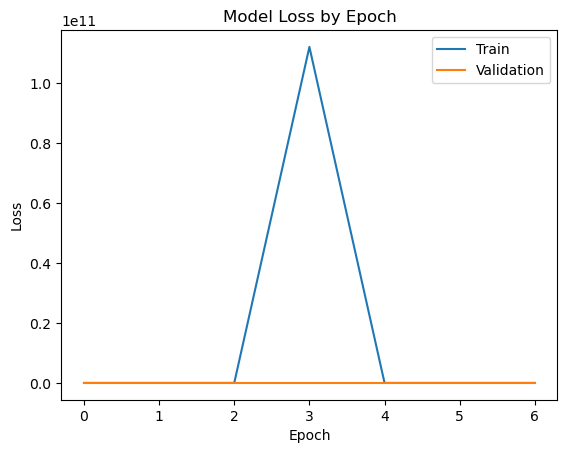

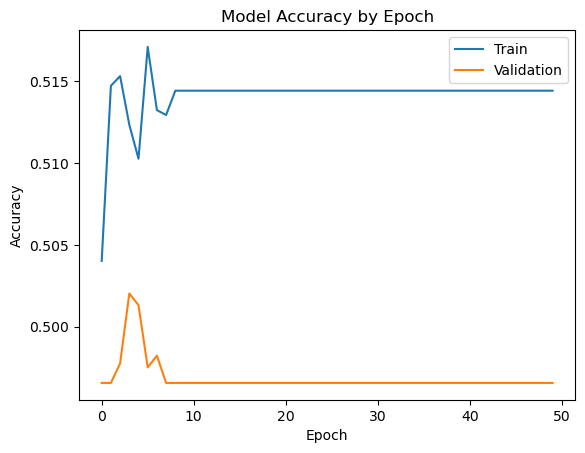

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
[[2087    0]
 [2116    0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2087
           1       0.00      0.00      0.00      2116

    accuracy                           0.50      4203
   macro avg       0.25      0.50      0.33      4203
weighted avg       0.25      0.50      0.33      4203

F1 Score: 0.0


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [14]:
# Plotting the Loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")